<a href="https://colab.research.google.com/github/davidsjohnson/wise24_xai_ac/blob/main/notebooks/tutorial_audio_xai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook 2 - Explaining Speech Emotion Recognition

In this notebook you will attempt to explanations of a speech emotion recognition (SER) task using tabular data and a XGBoost classifier. As well as a CNN trained on spectrograms.

To use this notebook, please make sure to go step by step through each of the cells review the code and comments along the way.

Make sure to read the Notebook 2 section of the **README** beforing starting this notebook for all installation instructions.

## Notebook Setup

Make sure to uncomment code based on if you are running locally or via Google Colab

In [1]:
# uncomment and run this cell to use Google Colab
# !git clone https://github.com/davidsjohnson/wise24_xai_ac.git

In [2]:
import sys
import os
sys.path.append(os.path.realpath('../'))  # uncomment this line if you are running this notebook locally
# sys.path.append(os.path.realpath('wise24_xai_ac')) # uncomment this line if you are running this notebook on Google Colab

In [3]:
from pathlib import Path

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
import torch.nn as nn

import librosa
import librosa.display

import matplotlib.pyplot as plt

from IPython.display import Audio
import IPython

import utils
import models
import evaluate

In [4]:
colab = False  # change to true if using Google Colab
base_dir = Path('../data/') if not colab else Path('wise24_xai_ac/data/')

## Setup Datasets

### Download Data and Extract Features

First we need to load our datast.  For this task, we will be using the audio portion of the [Ravdess dataset](https://www.kaggle.com/datasets/uwrfkaggler/ravdess-emotional-speech-audio).  

For the tabular dataset, we provide you with preextracted features in the form of a pandas dataframe.  Tabular features were extracted with the [openSmile](https://audeering.github.io/opensmile-python/) package using the [Extended Geneva Minimalistic Acoustic Parameter
Set (EGeMAPS)](https://mediatum.ub.tum.de/doc/1523509/file.pdf). Please have a look at the paper for a detailed explanation of the different features.

We will also extract Spectrograms from the audio clips using librosa.

We are also providing 300 audio clips of the test dataset containing actors \[15,  8, 20, 11,  5\]

In [5]:
ravdess_link = 'https://zenodo.org/record/1188976/files/Audio_Speech_Actors_01-24.zip?download=1'
data_dir = utils.download_file(url=ravdess_link,
                               file_name="ravdess.zip",
                               cache_dir= './data/ravdess',
                               extract=True,
                               force_download=False,
                               archive_folder='')
data_dir

File downloaded to: data/ravdess/ravdess.zip


PosixPath('data/ravdess')

### Load the RAVDESS extracted Features

In [6]:
LABEL_DICT = {0:'neutral', 1:'calm', 2:'happy', 3:'sad', 4:'angry', 5:'fear', 6:'disgust', 7:'surprise'}
LABEL_MAP_DICT = {v: k for k, v in LABEL_DICT.items()}
LABELS = list(LABEL_DICT.values())

# load dataframes from CSV
df_train = pd.read_csv(base_dir / 'ravdess_features/radvess_opensmile_train.csv')
df_test = pd.read_csv(base_dir / 'ravdess_features/radvess_opensmile_test.csv')

# update audio_paths to match new locations
audio_path = base_dir / 'ravdess_audioclips'
def update_paths(row):
    return str(audio_path / Path(row.path).name)
df_train.path = df_train.apply(update_paths, axis='columns')
df_test.path = df_test.apply(update_paths, axis='columns')

# get feature columns
feature_names = list(df_train.columns[6:])
print(feature_names)

['F0semitoneFrom27.5Hz_sma3nz_amean', 'F0semitoneFrom27.5Hz_sma3nz_stddevNorm', 'F0semitoneFrom27.5Hz_sma3nz_percentile20.0', 'F0semitoneFrom27.5Hz_sma3nz_percentile50.0', 'F0semitoneFrom27.5Hz_sma3nz_percentile80.0', 'F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2', 'F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope', 'F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope', 'F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope', 'F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope', 'loudness_sma3_amean', 'loudness_sma3_stddevNorm', 'loudness_sma3_percentile20.0', 'loudness_sma3_percentile50.0', 'loudness_sma3_percentile80.0', 'loudness_sma3_pctlrange0-2', 'loudness_sma3_meanRisingSlope', 'loudness_sma3_stddevRisingSlope', 'loudness_sma3_meanFallingSlope', 'loudness_sma3_stddevFallingSlope', 'spectralFlux_sma3_amean', 'spectralFlux_sma3_stddevNorm', 'mfcc1_sma3_amean', 'mfcc1_sma3_stddevNorm', 'mfcc2_sma3_amean', 'mfcc2_sma3_stddevNorm', 'mfcc3_sma3_amean', 'mfcc3_sma3_stddevNorm', 'mfcc4_sma3_amean', 'mfcc4_sma3_std

### Review the Extracted Features

In [7]:
# review a random sample of the training data
df_train.sample(5)

Unnamed: 0  actor  emotion  intensity  \
1002        1062      3        4          1   
64            64     16        2          1   
680          680      6        5          2   
70            70     16        6          2   
862          862      4        3          2   

                                                   path emotion_label  \
1002  ../data/ravdess_audioclips/03-01-05-01-01-01-0...         angry   
64    ../data/ravdess_audioclips/03-01-03-01-02-01-1...         happy   
680   ../data/ravdess_audioclips/03-01-06-02-01-02-0...          fear   
70    ../data/ravdess_audioclips/03-01-07-02-02-02-1...       disgust   
862   ../data/ravdess_audioclips/03-01-04-02-02-01-0...           sad   

      F0semitoneFrom27.5Hz_sma3nz_amean  \
1002                          23.023859   
64                            34.454590   
680                           55.346119   
70                            35.752953   
862                           49.905739   

      F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
1002                                0.099156   
64                                  0.087642   
680                                 0.076040   
70                                  0.073346   
862                                 0.095982   

      F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
1002                                   21.149364   
64                                     31.992432   
680                                    54.271973   
70                                     33.414112   
862                                    48.750450   

      F0semitoneFrom27.5Hz_sma3nz_percentile50.0  ...  \
1002                                   22.660233  ...   
64                                     33.751865  ...   
680                                    56.348244  ...   
70                                     36.629314  ...   
862                                    51.167145  ...   

      slopeUV0-500_sma3nz_amean  slopeUV500-1500_sma3nz_amean  \
1002                   0.072856                      0.007994   
64                     0.061815                      0.002180   
680                    0.054339                     -0.003050   
70                     0.083790                      0.010936   
862                    0.106594                      0.008118   

      spectralFluxUV_sma3nz_amean  loudnessPeaksPerSec  VoicedSegmentsPerSec  \
1002                     0.016591             2.506266              1.781171   
64                       0.007507             1.881720              0.817439   
680                      0.027940             2.228412              0.847458   
70                       0.023224             2.427185              1.228501   
862                      0.016541             2.659575              0.808625   

      MeanVoicedSegmentLengthSec  StddevVoicedSegmentLengthSec  \
1002                    0.165714                      0.061146   
64                      0.486667                      0.145220   
680                     0.676667                      0.751236   
70                      0.314000                      0.239800   
862                     0.516667                      0.089938   

      MeanUnvoicedSegmentLength  StddevUnvoicedSegmentLength  \
1002                   0.327500                     0.399148   
64                     0.535000                     0.438891   
680                    0.360000                     0.317096   
70                     0.398333                     0.424948   
862                    0.522500                     0.444543   

      equivalentSoundLevel_dBp  
1002                -47.849052  
64                  -38.541653  
680                 -21.082924  
70                  -35.806618  
862                 -25.931696  

[5 rows x 94 columns]

In [8]:
# review the extracted features

audio_sample = df_test.sample(1)
audio_sample

Unnamed: 0  actor  emotion  intensity  \
107        1127     20        5          1   

                                                  path emotion_label  \
107  ../data/ravdess_audioclips/03-01-06-01-01-02-2...          fear   

     F0semitoneFrom27.5Hz_sma3nz_amean  \
107                          39.088825   

     F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
107                                 0.07409   

     F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
107                                   37.696171   

     F0semitoneFrom27.5Hz_sma3nz_percentile50.0  ...  \
107                                   39.185017  ...   

     slopeUV0-500_sma3nz_amean  slopeUV500-1500_sma3nz_amean  \
107                   0.117119                      0.010932   

     spectralFluxUV_sma3nz_amean  loudnessPeaksPerSec  VoicedSegmentsPerSec  \
107                     0.005327             1.834862              0.928074   

     MeanVoicedSegmentLengthSec  StddevVoicedSegmentLengthSec  \
107                       0.255                      0.237645   

     MeanUnvoicedSegmentLength  StddevUnvoicedSegmentLength  \
107                       0.64                     0.482825   

     equivalentSoundLevel_dBp  
107                -48.601334  

[1 rows x 94 columns]

In [9]:
# Display Audio to list to
Audio(audio_sample['path'].values[0])

In [10]:
# basepath = Path('./output')

# output_path = basepath / 'ravdess'
# feature_path = output_path / 'features'
# audio_path = output_path / 'audio_clips'
# model_path = output_path /'model'

# os.makedirs(feature_path, exist_ok=True)
# os.makedirs(audio_path, exist_ok=True)

### Extract Spectrograms

In [11]:
def get_log_melspec(data, sample_rate, silence_thresh=25):
  """
  Function for extracting features from an audio sample.  The audio is preprocess to remove silence and then
  padded on both sides to ensure each clip is 5 seconds.
  Then the log mel spectrogram is extracted.
  """
  trimmed, _ = librosa.effects.trim(data, top_db=silence_thresh)
  padded = np.pad(trimmed, (int(sample_rate*2.5-len(trimmed)//2), int(sample_rate*2.5-len(trimmed)//2)), 'constant')
  mel = librosa.feature.melspectrogram(y=padded, sr=sample_rate, n_fft=2048, hop_length=512, n_mels=128)
  return librosa.power_to_db(mel, ref=np.max)

In [12]:
# setup dictionary to store data
data = dict(
    actor = [],
    emotion = [],
    intensity = [],
    gender = [],
    path = []
)

# final all wave files
wav_files = data_dir.rglob('*.wav')

# process each file
for wav in wav_files:

    # extract details from filename (see zenodo page for details)
    _, _, emo, emo_int, _, _, actor = wav.stem.split('-')

    data['actor'].append(int(actor))
    data['emotion'].append(int(emo)-1)
    data['intensity'].append(int(emo_int))
    data['gender'].append('male' if int(actor) % 2 == 0 else 'female')
    data['path'].append(str(wav))

df_rav = pd.DataFrame.from_dict(data)
df_rav['emotion_label'] = df_rav.emotion.replace(LABEL_DICT, inplace=False)

# extract features and save to dataframe
def load_melspec(row):
  a, sr = librosa.load(row['path'], sr=16000)
  return get_log_melspec(a, sr, silence_thresh=55)

df_rav['spectro'] = df_rav.apply(load_melspec, axis=1)

In [13]:
# validate extracted features
for idx, row in df_rav.iterrows():
  assert row.spectro.shape == (128, 157), f'shape: {row.spectro.shape}'

### Review the Spectrogram Data

In [14]:
# review one row
audio_sample = df_rav.sample(1)
audio_sample

actor  emotion  intensity gender  \
229     20        5          2   male   

                                               path emotion_label  \
229  data/ravdess/Actor_20/03-01-06-02-01-02-20.wav          fear   

                                               spectro  
229  [[-80.0, -80.0, -80.0, -80.0, -80.0, -80.0, -8...

In [15]:
# Display Audio to list to
Audio(audio_sample['path'].values[0])

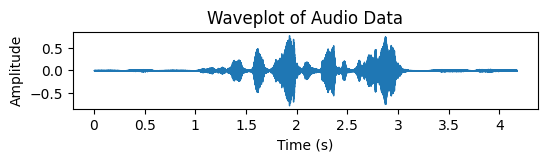

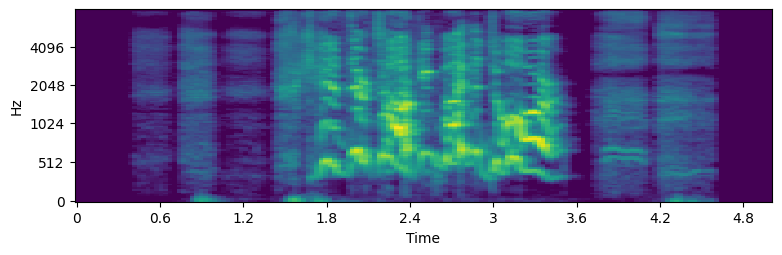

In [16]:
# load audio and downsample to 16000
y, sr = librosa.load(audio_sample['path'].values[0], sr=16000)

# Create wave plot
plt.figure(figsize=(6, 1))
librosa.display.waveshow(y, sr=sr)
plt.title('Waveplot of Audio Data')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

plt.figure(figsize=(9,2.5))
librosa.display.specshow(audio_sample['spectro'].values[0],
                         sr=sr, hop_length=512, n_fft=2048,
                         x_axis='time', y_axis='mel',
                         cmap = 'viridis'
                         )
plt.show()

## Explain Tabular Data for FER

### Train an XGBoost Model

Now we train an XGBoost model to perform explanations.  The model should get $100\%$ on the training data.

In [17]:
from xgboost import XGBClassifier

In [18]:
random_state = 24

xgb = XGBClassifier(n_estimators=20, 
                    max_depth=15,
                    learning_rate=0.1, 
                    objective='binary:logistic',
                    random_state=random_state)

xgb.fit(df_train[feature_names], df_train['emotion'])
score = xgb.score(df_train[feature_names], df_train['emotion'])
print(f'Train Accuracy: {score*100:.2f}%')

Train Accuracy: 100.00%


### Evaluate the model

Now let's evaluate the performance of the RDF Classifier on the `X_aus` dataset. The accuracy should be around $45.67\%$, indicating significant overfitting. However, it is much better than random guessing at $12.5\%$

We should also generate the predictions of the model for the dataset, and store them in the dataframe.

In [19]:
score = xgb.score(df_test[feature_names], df_test['emotion'])
print(f'Test Accuracy: {score*100:.2f}%')

# generate predictions for later user
df_test['emotion_pred'] = xgb.predict(df_test[feature_names])
(df_test['emotion_pred'] == df_test['emotion']).mean()

Test Accuracy: 45.67%


0.45666666666666667

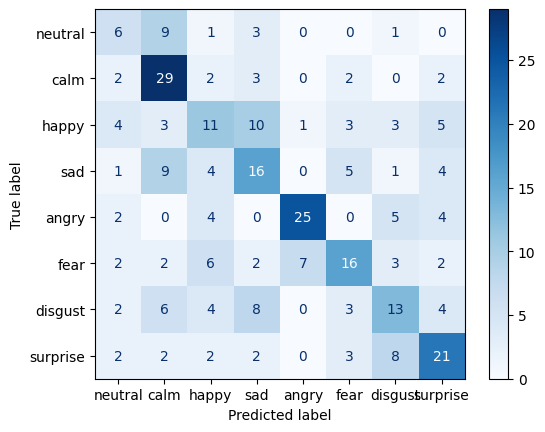

In [20]:
cm = confusion_matrix(df_test['emotion'], df_test['emotion_pred'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=LABELS)
disp.plot(cmap='Blues')
plt.grid(False)

#### Review some predictions

In [21]:
audio_samples = df_test.sample(5)
for idx, sample in audio_samples.iterrows():
    print(f'Index: {idx} - Emotion: {sample.emotion_label} | Prediction: {LABELS[sample.emotion_pred]}')
    print(sample.path)
    IPython.display.display(IPython.display.Audio(sample.path))

Index: 161 - Emotion: happy | Prediction: sad
../data/ravdess_audioclips/03-01-03-01-01-01-11.wav


Index: 172 - Emotion: angry | Prediction: angry
../data/ravdess_audioclips/03-01-05-02-02-01-11.wav


Index: 37 - Emotion: disgust | Prediction: disgust
../data/ravdess_audioclips/03-01-07-02-02-01-05.wav


Index: 298 - Emotion: disgust | Prediction: happy
../data/ravdess_audioclips/03-01-07-01-02-02-15.wav


Index: 190 - Emotion: neutral | Prediction: calm
../data/ravdess_audioclips/03-01-01-01-01-02-08.wav


### Generate Explanations

More to come in tutorial...

## Explainations of Spectrograms

### Setup Data Loaders

In [22]:
# # split dataset by actors
# all_actors = df_rav['actor'].unique()
# actors_gender = df_rav.groupby('actor')['gender'].unique().reset_index()

# train_actors, tmp = train_test_split(actors_gender, train_size=10, stratify=actors_gender['gender'], random_state=36851234)
# val_actors, test_actors = train_test_split(tmp, train_size=8, stratify=tmp['gender'], random_state=36851234)

# train_actors = train_actors['actor'].tolist()
# val_actors = val_actors['actor'].tolist()
# test_actors = test_actors['actor'].tolist()

# df_train = df_rav[df_rav['actor'].isin(train_actors)]
# df_val = df_rav[df_rav['actor'].isin(val_actors)]
# df_test = df_rav[df_rav['actor'].isin(test_actors)]

In [23]:
# Random data set split
df_train_cnn = df_rav.sample(frac=.8, random_state=0)
df_val_cnn = df_rav.drop(df_train_cnn.index).sample(frac=.5, random_state=0)
df_test_cnn = df_rav.drop(df_train_cnn.index).drop(df_val_cnn.index)

In [24]:
def get_dataset(df, feats_col, labels_col):
  labels = df[labels_col].values

  # convert from object array in dataframe to floats
  # and convert to numpy array
  feats = df[feats_col]
  feats = [f.astype(float) for f in feats]
  feats = np.array(feats)
  feats = feats[:, None, :, :]

  idxs = df.index.values

  # Setup features and labels as tensors
  X = torch.tensor(feats, dtype=torch.float32)
  y = torch.tensor(labels, dtype=torch.long)
  idxs = torch.tensor(idxs, dtype=torch.long)

  # Create TensorDataset
  dataset = TensorDataset(X, y, idxs)

  return dataset

In [25]:
# setup dataloaders based on previous dataset split
ds_train = get_dataset(df_train_cnn, 'spectro', 'emotion')
ds_val = get_dataset(df_val_cnn, 'spectro', 'emotion')
ds_test = get_dataset(df_test_cnn, 'spectro', 'emotion')

dl_train = DataLoader(ds_train, batch_size=64, shuffle=True)
dl_val = DataLoader(ds_val, batch_size=1, shuffle=False)
dl_test = DataLoader(ds_test, batch_size=1, shuffle=False)

### Load Pretrained Model

In [26]:
# get checkpoint
ckpt_link = 'https://uni-bielefeld.sciebo.de/s/eiOiBrhuOENmo0p/download'
ckpt_path = utils.download_file(ckpt_link,
                                'ravdess_model.pth',
                                cache_dir='./data/ravdess/model',
                                extract=False,
                                force_download=False
                                )
ckpt_path

File downloaded to: data/ravdess/model/ravdess_model.pth


PosixPath('data/ravdess/model/ravdess_model.pth')

In [27]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [28]:
# To load the best model:
model = models.ResNet(len(LABELS))
model.load_state_dict(torch.load(ckpt_path, map_location='cpu'))
model.to(device);

### Evaluate Model

Next we will evaluate the loaded model to ensure it is working as expected.  You should get around $92.36\%$ accurac on the test set. The accuracy is high, because the model was not split between actors as we did in the previous example

In [29]:
evaluate.evaluate_model(model, dl_train, criterion, device)
evaluate.evaluate_model(model, dl_val, criterion, device)
_, _, test_preds, test_probs = evaluate.evaluate_model(model, dl_test, criterion, device)

Evaluation Loss: 0.2378, Evaluation Accuracy: 0.9349
Evaluation Loss: 0.0925, Evaluation Accuracy: 0.9792
Evaluation Loss: 0.1880, Evaluation Accuracy: 0.9236


In [30]:
# load probabilities and predictions into dataframe for test dataset
df_test_cnn['emotion_pred'] = test_preds
(df_test_cnn['emotion'] == df_test_cnn['emotion_pred']).mean()

0.9236111111111112

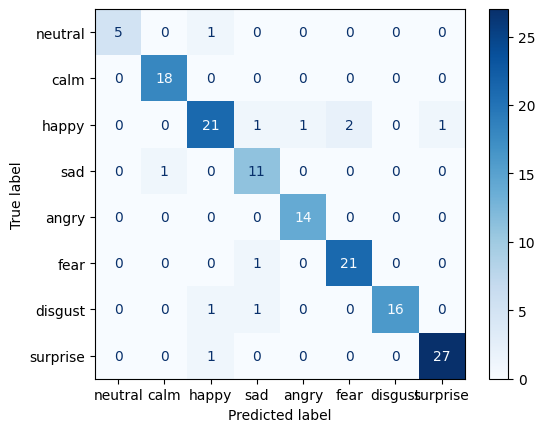

In [31]:
cm = confusion_matrix(df_test_cnn['emotion'], df_test_cnn['emotion_pred'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=LABELS)
disp.plot(cmap='Blues')
plt.grid(False)

#### Review some predictions

In [32]:
audio_samples = df_test_cnn.sample(5)
for idx, sample in audio_samples.iterrows():
    print(f'Index: {idx} - Emotion: {sample.emotion_label} | Prediction: {LABELS[sample.emotion_pred]}')
    print(sample.path)
    IPython.display.display(IPython.display.Audio(sample.path))

Index: 1376 - Emotion: calm | Prediction: calm
data/ravdess/Actor_01/03-01-02-01-01-01-01.wav


Index: 1251 - Emotion: surprise | Prediction: surprise
data/ravdess/Actor_07/03-01-08-02-01-01-07.wav


Index: 136 - Emotion: fear | Prediction: fear
data/ravdess/Actor_18/03-01-06-01-02-01-18.wav


Index: 909 - Emotion: sad | Prediction: sad
data/ravdess/Actor_24/03-01-04-01-02-02-24.wav


Index: 498 - Emotion: fear | Prediction: fear
data/ravdess/Actor_04/03-01-06-02-02-01-04.wav


### Generate Explanations

More to come..